# High-Dimensional Bayesian Optimization with SAASBO


This tutorial shows how to use the Sparse Axis-Aligned Subspace Bayesian Optimization (SAASBO) method for high-dimensional Bayesian optimization [1]. SAASBO uses sparse axis-aligned subspace priors to avoid overfitting. Specifically, SAASBO uses a hierarchical sparsity prior consisting of a global shrinkage parameter with a Half-Cauchy prior $\tau \sim \mathcal{HC}(\beta)$ and inverse lengthscales $\rho_d \sim \mathcal{HC}(\tau)$ for $d=1, ..., D$. See [1] for details.

[1] D. Eriksson, M. Jankowiak. High-Dimensional Bayesian Optimization with Sparse Axis-Aligned Subspaces. Proceedings of the Thirty-Seventh Conference on Uncertainty in Artificial Intelligence, 2021.

In [1]:
from ax import ParameterType, RangeParameter, SearchSpace, SimpleExperiment
from ax.benchmark.benchmark import full_benchmark_run
from ax.benchmark.benchmark_result import aggregate_problem_results, BenchmarkResult
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models

In [2]:
import torch
tkwargs = {
    "dtype": torch.double, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

## Setup methods

This tutorial uses Ax Developer API with the Ax benchmarking suite, but the generation strategy created here cam be used in any Ax API, including Service API and `Scheduler`. Additional resources:
- To learn about different APIs in Ax: https://ax.dev/docs/api.html.
- To learn more about the developer API, refer to the dedicated tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html. 
- To learn more about the generation strategy setup: https://ax.dev/tutorials/generation_strategy.html.

In [3]:
gpei = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL, 
            num_trials=10,  # How many trials should be produced from this generation step
            min_trials_observed=5,  # How many trials need to be completed to move to next model
            max_parallelism=None,  # Max parallelism for this step; `None` means no limit
        ),
        GenerationStep(
            model=Models.BOTORCH, 
            num_trials=-1, 
            max_parallelism=5,
        ),
    ],
    name="Sobol+GPEI"
)

saasbo = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL, 
            num_trials=10,
            min_trials_observed=5,
            max_parallelism=-1,
        ),
        GenerationStep(
            model=Models.FULLYBAYESIAN, 
            num_trials=-1, 
            max_parallelism=5,
            model_kwargs={  # Any kwargs you want passed into the model
                "num_samples": 256,
                "warmup_steps": 512,
                "disable_progbar": True,
                "torch_device": tkwargs["device"],
                "torch_dtype": tkwargs["dtype"],
            },
        ),
    ],
    name="SAASBO"
)

## Setup search space and metric
In this simple experiment we use the Branin function embedded in a 30-dimensional space. Additional resources:
- To set up a custom metric for your problem, refer to the dedicated section of the Developer API tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html#8.-Defining-custom-metrics.
- To avoid needing to setup up custom metrics by Ax Service API: https://ax.dev/tutorials/gpei_hartmann_service.html.

In [4]:
from ax.core.objective import Objective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.branin import BraninMetric
from ax.benchmark.benchmark_problem import BenchmarkProblem


branin_30 = BenchmarkProblem(
    name="Branin, D=30",
    optimal_value=0.397887,
    optimization_config=OptimizationConfig(
        objective=Objective(
            metric=BraninMetric(
                name="objective", param_names=["x9", "x24"], noise_sd=0.0
            ),
            minimize=True,
        )
    ),
    search_space=SearchSpace(
        parameters=[
            RangeParameter(
                name=f"x{i}", parameter_type=ParameterType.FLOAT, lower=-5.0, upper=10.0
            )
            for i in range(15)
        ]
        + [
            RangeParameter(
                name=f"x{i + 15}",
                parameter_type=ParameterType.FLOAT,
                lower=0.0,
                upper=15.0,
            )
            for i in range(15)
        ]
    ),
    evaluate_suggested=False,
)

## Run benchmark

In [ ]:
benchmarking_experiments = full_benchmark_run(
    problem_groups={"default": [branin_30]},
    method_groups={"default": [gpei, saasbo]},
    num_replications=1,
    num_trials=30,
    batch_size=1,
    raise_all_exceptions=True,
    verbose_logging=True
)

## Aggregate results

In [6]:
res = aggregate_problem_results(benchmarking_experiments[branin_30.name], problem=branin_30)

res_gp_ei = res.true_performance['Sobol+GPEI'].ravel()
res_saasbo = res.true_performance["SAASBO"].ravel()

## Plot results

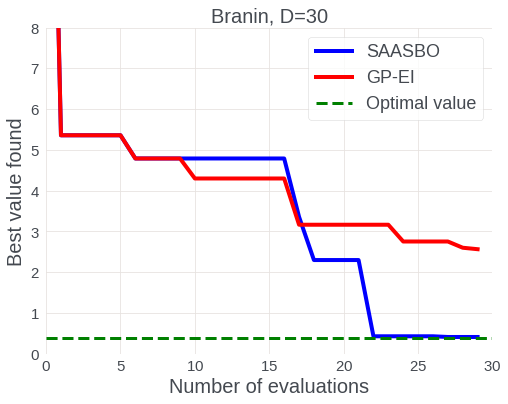

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.minimum.accumulate(res_saasbo), color="b", label="SAASBO")
ax.plot(np.minimum.accumulate(res_gp_ei), color="r", label="GP-EI")
ax.plot([0, len(res_saasbo)], [res.optimum, res.optimum], "--", c="g", lw=3, label="Optimal value")
ax.grid(True)
ax.set_title("Branin, D=30", fontsize=20)
ax.set_xlabel("Number of evaluations", fontsize=20)
ax.set_xlim([0, len(res_saasbo)])
ax.set_ylabel("Best value found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()